In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
import math
from IPython.display import display, Math, HTML
import matplotlib.animation as animation

In [ ]:
from numpy import f2py
with open("isingmetro.f90") as sourcefile:
    sourcecode = sourcefile.read()
f2py.compile(sourcecode, modulename='isingf', verbose=0)
from isingf import isingf

In [2]:
!rm ising.pyf
!python3 -m numpy.f2py isingmetro.f90 -m isingf -h ising.pyf
!python3 -m numpy.f2py -c ising.pyf isingmetro.f90
from isingf import isingf

rm: cannot remove 'ising.pyf': No such file or directory
Reading fortran codes...
	Reading file 'isingmetro.f90' (format:free)
Post-processing...
	Block: isingf
			Block: isingf
				Block: init
				Block: alloc
				Block: metropolis
				Block: deltaepbc
				Block: deltaeobc
Post-processing (stage 2)...
	Block: isingf
		Block: unknown_interface
			Block: isingf
				Block: init
				Block: alloc
				Block: metropolis
				Block: deltaepbc
				Block: deltaeobc
Saving signatures to file "./ising.pyf"
{'attrspec': ['public']}
In: :isingf:isingmetro.f90:isingf
vars2fortran: No typespec for argument "init".
{'attrspec': ['public']}
In: :isingf:isingmetro.f90:isingf
vars2fortran: No typespec for argument "metropolis".
{'attrspec': ['public']}
In: :isingf:isingmetro.f90:isingf
vars2fortran: No typespec for argument "deltaepbc".
{'attrspec': ['public']}
In: :isingf:isingmetro.f90:isingf
vars2fortran: No typespec for argument "deltaeobc".
running build
running config_cc
unifing config_cc, config, b

# 1. Ising Model on a square lattice
Write a code for a 2D Ising model on a square lattice in equilibrium with a thermal bath, without external magnetic field, using the spin flip dynamics (considered as an actual temporal evolution process), and periodic boundary conditions (PBC). See for instance the code ising.f90.  
A useful reference paper is D.P. Landau, Phys. Rev. B 13, 2997 (1976).  
Input parameters are:
1. $L$ (linear lattice dimension, which gives the number of spins: $N=L \text{x} L$),
2. $n_{mcs}$ (number of total MC steps per spin)
3. $n_{equil}$ (number of equilibration MC steps per spin)
4. $T$ (temperature of the thermal bath).

Quantities of interest are:
1. the magnetization per spin:

$$\frac{M}{N}=\frac{1}{N}\sum_{i=1}^Ns_i;$$

2. the energy per spin, with $\langle i, j \rangle$ all over the nearest neighbor pairs:

$$\frac{E}{N}=-\frac{J}{N}\sum_{\langle i, j\rangle}^Ns_i s_j;$$

and quantities related to them, such as time (ensemble) averages, that we denote with $\langle \rangle$,
and response functions, i.e., the heat capacity per spin:

$$C = (\langle E^2 \rangle−\langle E \rangle^2)/k_BT^2N,$$

and the magnetic susceptibility per spin, in absence of an external magnetic field:

$$\chi = (\langle M^2 \rangle − \langle M \rangle^2)/k_BTN$$

Consider units such that $k_B=1$, $J=1$.

In [10]:
class Ising:
    '''
    This class implements 
    the 2D Ising model
    on a square lattice in PBCs
    '''
    
    def __init__(self,L,T,J,k_B,boundary_conditions,N_equi,N_mcs,mc_step_selection="random",fortran=False,spin_i='random', gif_spin=False):
        'Initialize the Ising model'
        self.L = L
        self.N = L**2
        self.T = T
        self.J= J
        self.k_B= k_B
        self.spin_i=spin_i
        self.boundary_conditions=boundary_conditions
        self.mc_step_selection=mc_step_selection
        self.M = 0
        self.M_N = None
        self.E = 0
        self.E_N = None
        self.E_N_av = None
        self.M_N_av = None
        self.fortran=fortran
        self.rng = np.random.default_rng(seed=50)
        self.spin = np.ones((L,L))
        self.spins = np.zeros((N_equi+N_mcs+1,L,L))
        self.gif_spin = gif_spin
        self.w_dict = {}
        self.acc = 0
        self.counter = 0
        self.i=0
        self.N_equi = N_equi
        self.N_mcs = N_mcs
        self.data = np.zeros((N_equi+N_mcs+1,2))
        self.datae = np.zeros((N_mcs+N_equi)*self.N+1)
        self.datac = np.zeros((N_mcs+N_equi)*self.N+1)
        self.data_=[]
        self.ar = None
        self.var = None
        self.c_heat = None
        self.chi_mag = None
        self.autocorr = []
        self.n_autocorr = 10
        self.data_filename = 'data.txt'
        self.data_filename_ = 'data_.txt'
    
    def make_pm(self,x):
        '''
        Convert random uniform array
        into array of -1 and +1
        '''
        def tmp(x):
            if x<0.5:
                return 1
            else:
                return -1
        f = np.frompyfunc(tmp, 1, 1)
        return f(x)
    
    def get_up_right_PBC(self,i,j):
        '''
        PBCs up/right
        '''
        if j==(self.L-1):
            up = 0
        else:
            up = j+1
        if i==(self.L-1):
            right = 0
        else:
            right = i+1
            
        return up,right
    
    def get_down_left_PBC(self,i,j):
        '''
        PBCs down/left
        '''
        if j==0:
            down = self.L-1
        else:
            down = j-1
        if i==0:
            left = self.L-1
        else:
            left = i-1
            
        return down,left
    
    
    
    def get_up_right_OBC(self,i,j):
        '''
        OBCs up/right
        '''
        if j==(self.L-1):
            up = 'obc'
        else:
            up = j+1
        if i==(self.L-1):
            right = 'obc'
        else:
            right = i+1
            
        return up,right
    
    def get_down_left_OBC(self,i,j):
        '''
        OBCs down/left
        '''
        if j==0:
            down = 'obc'
        else:
            down = j-1
        if i==0:
            left = 'obc'
        else:
            left = i-1
        return down,left
    
    def spin_initialization(self):
        '''
        Initialize spin.
        NB: this is used only at initialization.
        '''
        for i in range(self.L):
            for j in range(self.L):
                if self.spin_i == 'minus_one':
                    self.spin[i,j]=-1.0
                if self.spin_i=='chess':
                    if i%2==0:
                        if j%2==1:
                            self.spin[i,j]=-1
                    if i%2==1:
                        if j%2==0:
                            self.spin[i,j]=-1   
                if self.spin_i=='half':
                    if i<=self.L/2-1:
                        self.spin[i,j]=-1
        
    
    def calc_energy_PBC(self):
        '''
        Calculates the total energy.
        NB: this is used only at initialization.
        '''
        E = 0
        for j in range(self.L):
            for i in range(self.L):
                up,right = self.get_up_right_PBC(i,j)
                E = E - self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])
        return E
    
    def calc_energy_OBC(self):
        '''
        Calculates the total energy.
        NB: this is used only at initialization.
        '''
        E = 0
        for j in range(self.L):
            for i in range(self.L):
                up,right = self.get_up_right_OBC(i,j)
                if up=='obc' and right !='obc':
                    E = E - self.J*self.spin[i,j]*(self.spin[right,j])
                if right=='obc' and up !='obc':
                    E = E - self.J*self.spin[i,j]*(self.spin[i,up])
                if right!='obc' and up !='obc':
                    E = E - self.J*self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])
        return E    
                       
    def deltaE_PBC(self,i,j):
        '''
        Calculates change in energy for the spin flip
        '''
        up,right = self.get_up_right_PBC(i,j)
        down,left = self.get_down_left_PBC(i,j)
        res = 2.0*self.spin[i,j]*self.J*(self.spin[i,up]+self.spin[i,down]+self.spin[left,j]+self.spin[right,j])
        return (res,int(res))

    def deltaE_OBC(self,i,j):
        '''
        Calculates change in energy for the spin flip
        '''
        up,right = self.get_up_right_OBC(i,j)
        down,left = self.get_down_left_OBC(i,j)
        if up=='obc' and right !='obc' and down!='obc' and left!='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,down]+self.spin[left,j]+self.spin[right,j])
        if up!='obc' and right =='obc' and down!='obc' and left!='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,up]+self.spin[i,down]+self.spin[left,j])
        if up!='obc' and right !='obc' and down=='obc' and left!='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,up]+self.spin[left,j]+self.spin[right,j])
        if up!='obc' and right !='obc' and down!='obc' and left=='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,up]+self.spin[i,down]+self.spin[right,j])
        if up!='obc' and right!='obc' and down=='obc' and left=='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])
        if up!='obc' and right =='obc' and down=='obc' and left!='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,up]+self.spin[left,j])
        if up=='obc' and right!='obc' and down!='obc' and left=='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,down]+self.spin[right,j])
        if up=='obc' and right=='obc' and down!='obc' and left!='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,down]+self.spin[left,j])
        if up!='obc' and right!='obc' and down!='obc' and left!='obc':
            res = 2.0*self.J*self.spin[i,j]*(self.spin[i,up]+self.spin[i,down]+self.spin[left,j]+self.spin[right,j])
        return (res,int(res))
    
    def initialize(self):
        '''
        Initialization of the system:
        -spins are randomly configured
        -energy is calculated from scratch
        -dictionary with Metropolis' probability
        coefficents is created
        '''
        if self.spin_i=='random':
            r = self.rng.random((self.L,self.L))
            self.spin = self.make_pm(r)
        if self.spin_i!='one':
            self.spin_initialization()
        self.spins[self.i]=self.spin
        if self.fortran:
            isingf.t  = self.T
            isingf.j = self.J
            isingf.k = self.k_B
            isingf.l = self.L
            isingf.n = self.N
            isingf.bconditions = self.boundary_conditions
            isingf.mcsselection = self.mc_step_selection
            isingf.nequi=self.N_equi
            isingf.nmcs=self.N_mcs
            isingf.alloc()
            isingf.init()
            isingf.spin = self.spin
            self.M = np.sum(self.spin)
            isingf.m=self.M
            self.M_N = float(self.M)/float(self.N)
            if self.boundary_conditions=="PBC":
                self.E = self.calc_energy_PBC()
                isingf.e = self.E
            if self.boundary_conditions=="OBC":
                self.E = self.calc_energy_OBC()
                isingf.e = self.E
            self.data[0,0]=self.E
            self.data[0,1]=self.M
            self.datae[0]=self.E
            self.datac[0]=self.M
            self.i+=1
        else:
            self.M = np.sum(self.spin)
            self.M_N = self.M/float(self.N)
            if self.boundary_conditions=='PBC':
                self.E = self.calc_energy_PBC()
            if self.boundary_conditions=='OBC':
                self.E = self.calc_energy_OBC()
            self.E_N = self.E/float(self.N)
            self.data[0,0]=self.E
            self.data[0,1]=self.M
            self.data_.append((self.E,self.M))
            self.i+=1
            for dE in range(-8,8+1,4):
                self.w_dict[dE] = np.exp(-1.0*dE/(self.T*self.k_B))
            
    
    
    def metro_step(self):
        'One step of Metropolis spin flip dynamics'
        if self.fortran:
            isingf.metropolis()
            self.M = isingf.m
            self.M_N = self.M/float(self.N)
            self.E = isingf.e
            self.E_N = self.E/float(self.N)
            self.acc=isingf.accept
        else:
            if self.mc_step_selection=='ordered':
                for jj in range(self.L):
                    for ii in range(self.L):
                        if self.boundary_conditions=='PBC':
                            dE,dE_int = self.deltaE_PBC(ii,jj)
                            p=self.w_dict[dE_int]
                            rnd_w = self.rng.random()
                        if self.boundary_conditions=='OBC':
                            dE,dE_int = self.deltaE_OBC(ii,jj)
                            p = -1.0*dE_int*J/(self.T*self.k_B)
                            rnd_w = np.log(self.rng.random())
                        if (rnd_w<=p):
                            self.spin[ii,jj] = -1*self.spin[ii,jj]
                            self.acc += 1
                            self.M = self.M + 2* self.spin[ii,jj]
                            self.M_N = self.M/float(self.N)
                            self.E = self.E + dE
                            self.E_N = self.E/float(self.N)
                        self.data_.append((self.E,self.M))
            if self.mc_step_selection=='random':
                for _ in range(self.N):
                    (ii,jj) = self.rng.integers(0,high=self.L,size=2)
                    if self.boundary_conditions=='PBC':
                        dE,dE_int = self.deltaE_PBC(ii,jj)
                        p=self.w_dict[dE_int]
                        rnd_w = self.rng.random()
                    if self.boundary_conditions=='OBC':
                        dE,dE_int = self.deltaE_OBC(ii,jj)
                        p=-1.0*dE_int*J/(self.T*self.k_B)
                        rnd_w = np.log(self.rng.random())
                    if (rnd_w<=p):
                        self.spin[ii,jj] = -1*self.spin[ii,jj]
                        self.acc += 1
                        self.M = self.M + 2* self.spin[ii,jj]
                        self.M_N = self.M/float(self.N)
                        self.E = self.E + dE
                        self.E_N = self.E/float(self.N)
                    self.data_.append((self.E,self.M))

    def metro_driver(self,N_step):
        'Run N Metropolis steps of spin flip dynamics'
        for i in range(N_step):
            self.counter += self.N
            self.metro_step()
            if self.fortran:
                self.spin=isingf.spin
            self.spins[self.i]=self.spin
            self.data[self.i,0]=self.E
            self.data[self.i,1]=self.M
            self.i += 1          
            
    def ising_driver(self):
        '''
        Main driver for the Monte Carlo
        '''
        self.initialize()
        self.metro_driver(self.N_equi)
        self.metro_driver(self.N_mcs)
        self.data = np.array(self.data)
        self.data_ = np.array(self.data_)
        if self.fortran:
            for i in range((self.N_mcs+self.N_equi)*self.N):
                self.datae[i+1]=isingf.datae[i]
                self.datac[i+1]=isingf.datac[i]
        if self.gif_spin:
            self.spin_gif(self.spins,self.L,self.N_equi+self.N_mcs)
        np.savetxt(self.data_filename,self.data)
        np.savetxt(self.data_filename_,self.data)
    
    @staticmethod
    def plot_spin(spin):
        x,y = np.meshgrid(range(spin.shape[0]),range(spin.shape[1]))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.scatter(x,y,c=spin[x,y],label='Spin')
        plt.title('Spin Configuration')
        plt.show()

    @staticmethod
    def spin_gif(spin,L,frames):
        fig, ax = plt.subplots() 
        x,y = np.meshgrid(range(L),range(L))
        def update(frame):
            # clear the axis each frame
            ax.clear()
            # replot things
            ax.scatter(x,y,c=spin[frame][x,y])
        ani = animation.FuncAnimation(fig, update, frames=frames, interval=80)
        ani.save('scatter.gif')
        video = ani.to_html5_video()
        display(HTML(video))
        plt.close()
    
    @staticmethod
    def calc_autocorr(a,N):
        'Autocorrelation function'
        res = np.ones(N)
        for k in range(1,N):
            c_k = np.average(a[:-k]*a[k:]) 
            x_r = np.average(a[:-k])
            x_r_2 = np.average(a[:-k]**2)
            res[k] = (c_k-x_r**2)/(x_r_2-x_r**2)
        return res
    
    def get_stats(self,display=True):
        '''
        Calculate, store and print 
        statistical quantities
        '''
        self.ar = self.acc*1.0/self.counter
        self.E_N_av =np.average(self.data[:,0])/self.N
        self.M_N_av = np.average(self.data[:,1])/self.N
        self.c_heat = (np.average(self.data[:,0]**2)- (self.E_N_av*self.N)**2)/(self.T**2*self.N)
        self.chi_mag = (np.average(self.data[:,1]**2)- (self.M_N_av*self.N)**2)/(self.T**2*self.N)
        if display:
            print("Spin initialization:",self.spin_i)
            print("Total number of steps run = {}".format(self.counter/self.N))
            print("Acceptance ratio = {}".format(self.ar))
            print("Temperature = {}".format(self.T))
            print("<E/N> = {}".format(self.E_N_av))
            print("<M/N> = {}".format(self.M_N_av))
            print("Specific Heat = {}".format(self.c_heat))
            print("Magnetic Susceptibility = {}".format(self.chi_mag))

In [11]:
#Input Parameters
k_B=1
J=1

(a) Choose L=30, T=2, and initially $\text{spin}=\pm 1$ randomly. Calculate and plot the instantaneous values of energy $E/N$ and magnetization $M/N$ per particle as a function of Metropolis-Monte Carlo steps: how much time (i.e. how many nequil MC steps) is necessary to equilibrate the system? Plot the final snapshot of the spin pattern: does the system appear ordered or disordered? Calculate also $C$ and $\chi$.

We see that it takes 250/300 steps to equilibrate.
In this case the pattern is almost ordered.

Spin initialization: random
Total number of steps run = 2000.0
Acceptance ratio = 0.08403222222222222
Temperature = 2
<E/N> = -1.7302615358987172
<M/N> = 0.8896873785329558
Specific Heat = 1.9585077093303618
Magnetic Susceptibility = 2.3228400514607266


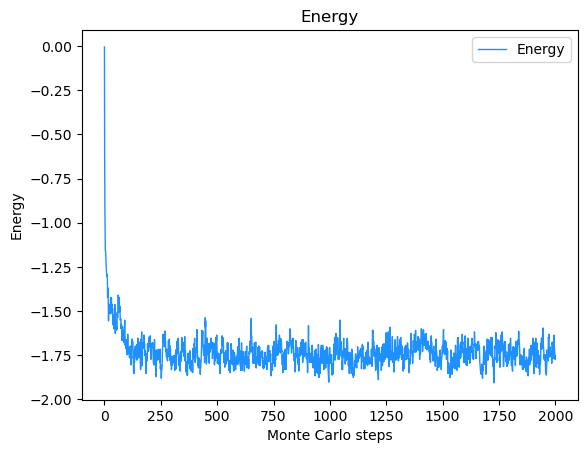

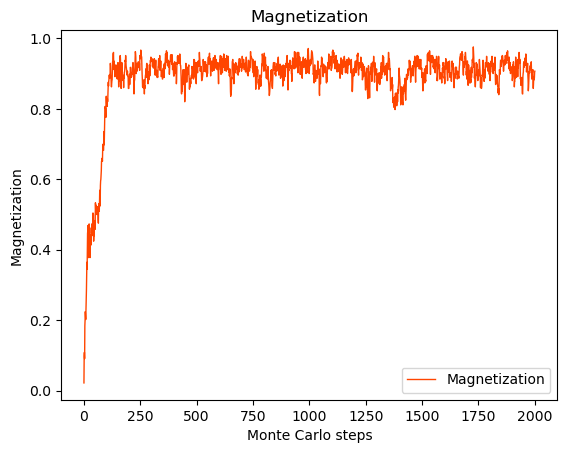

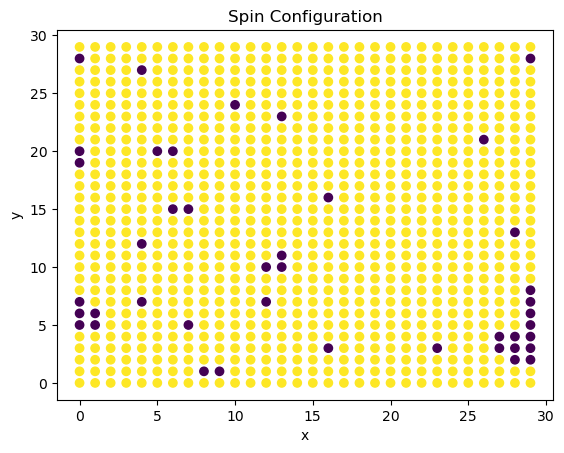

In [12]:
ising = Ising(30,2,J,k_B,"PBC",1000,1000)
ising.ising_driver()
ising.get_stats()

plt.title('Energy')    
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

(b) Choose T=4 and repeat (a).

At this temperature, the final pattern is chaotic, for this reason there is no equilibrium configuration.

Spin initialization: random
Total number of steps run = 2000.0
Acceptance ratio = 0.61006
Temperature = 4
<E/N> = -0.5567882725304014
<M/N> = 0.001608084846465656
Specific Heat = 0.173563809466254
Magnetic Susceptibility = 0.26362626629935626


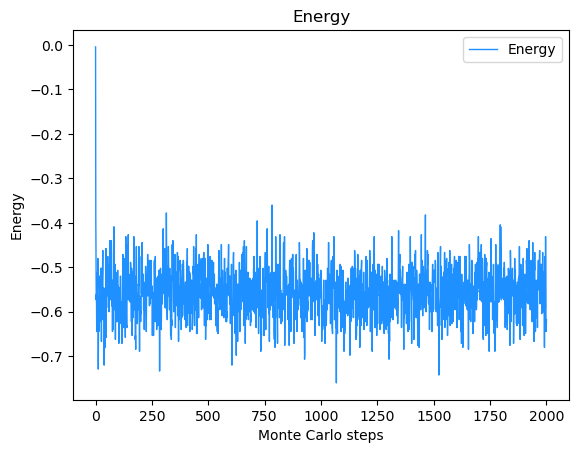

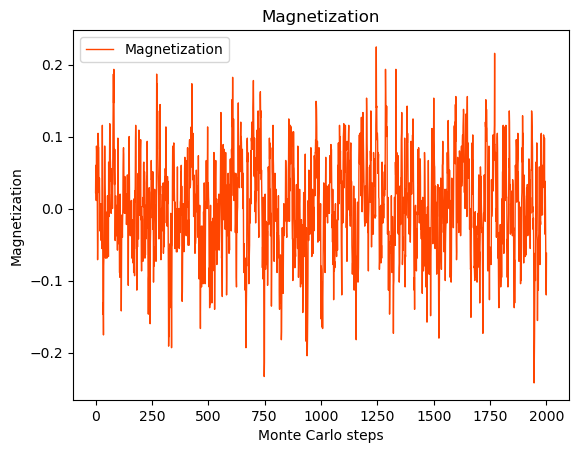

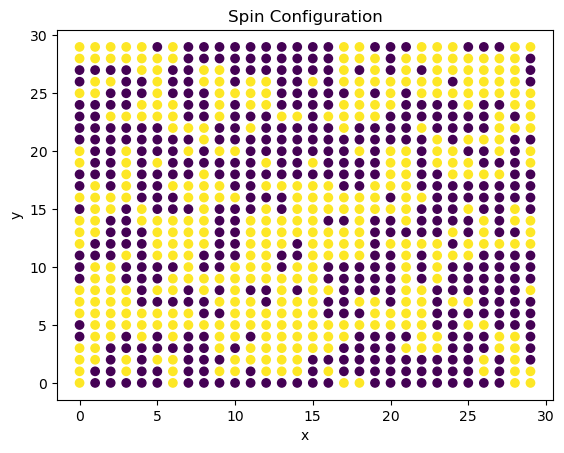

In [13]:
ising = Ising(30,4,J,k_B,"PBC",1000,1000)
ising.ising_driver()
ising.get_stats()

plt.title('Energy')    
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

(c) For fixed T, e.g. for T=1 or T=2, change the initial condition of magnetization (choose for instance some typical ordered configurations -all spins up, all spins down, alternatively up or down as on a chessboard, all left hand side spins up and all right hand side down, . . . ). Does the equilibration time change?

In this case we see that the steps needed for equilibration depend on the initial configuration.
In the case of chessboard configuration, in wich we have the maximum disorder, the equilibration time is the half.
In the case of all up configuration, in wich we have the maximum energy, the equilibration time is null.
In the case of all down configuration, in wich we have the maximum energy, the equilibration time is null.
In the case of half up configuration, in wich we have the maximum energy, the equilibration time is equal.

Spin initialization: chess
Total number of steps run = 2000.0
Acceptance ratio = 0.08711444444444444
Temperature = 2
<E/N> = -1.7199511355433394
<M/N> = -0.8769170970070521
Specific Heat = 3.734909785376189
Magnetic Susceptibility = 3.5634631781782242


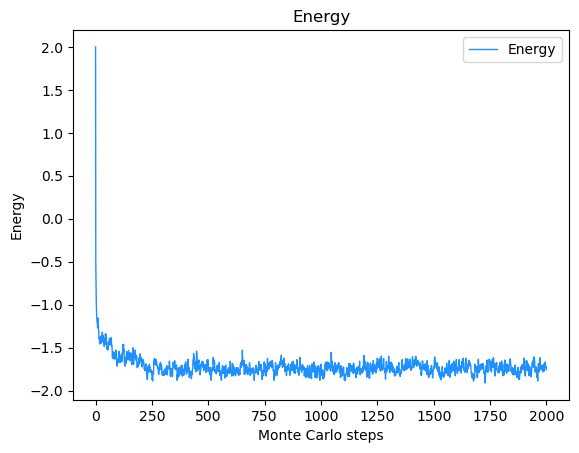

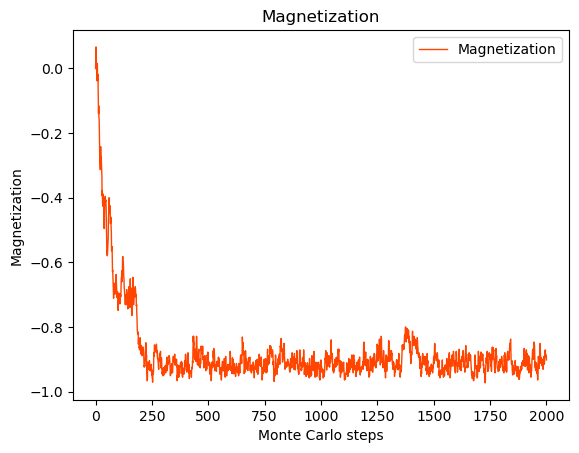

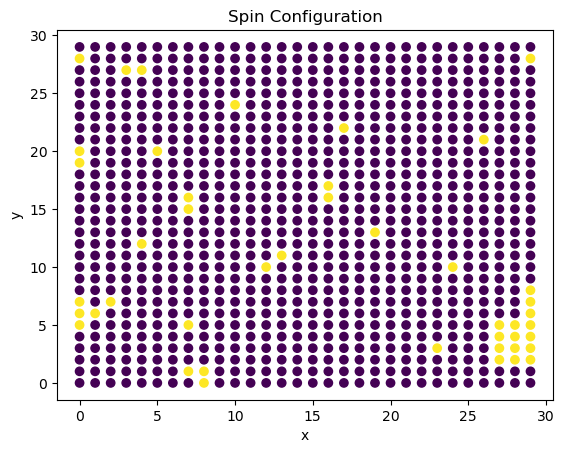

In [15]:
ising = Ising(30,2,J,k_B,'PBC',1000,1000,spin_i='chess')
ising.ising_driver()
ising.get_stats()

plt.title('Energy')    
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

Spin initialization: one
Total number of steps run = 2000.0
Acceptance ratio = 0.07929777777777777
Temperature = 2
<E/N> = -1.7444544394469432
<M/N> = 0.9111644177911045
Specific Heat = 0.7277211169528568
Magnetic Susceptibility = 0.18019592902199494


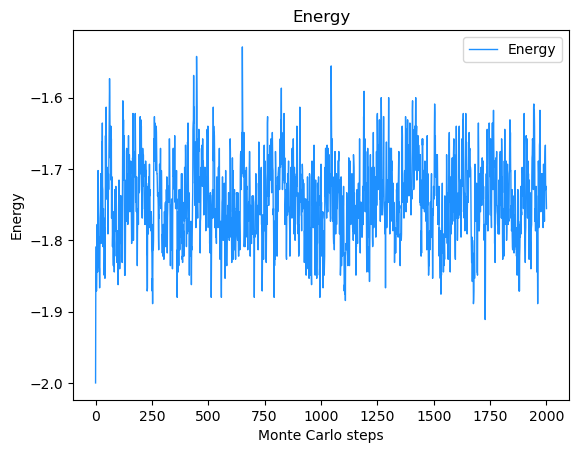

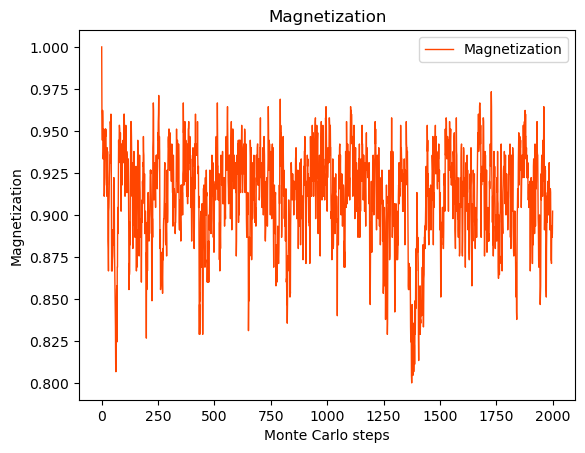

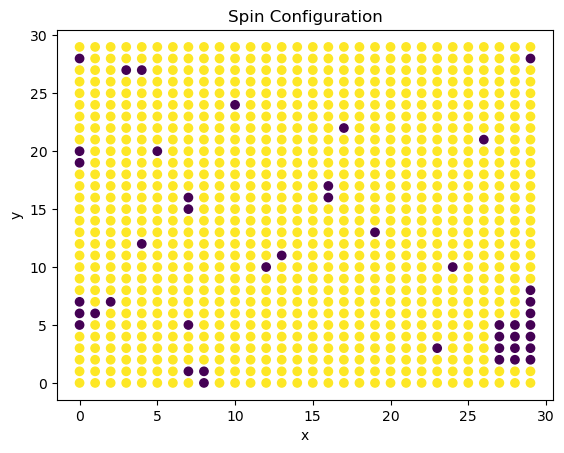

In [16]:
ising = Ising(30,2,J,k_B,'PBC',1000,1000,spin_i='one')
ising.ising_driver()
ising.get_stats()

plt.title('Energy')    
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

Spin initialization: minus_one
Total number of steps run = 2000.0
Acceptance ratio = 0.07929777777777777
Temperature = 2
<E/N> = -1.7444544394469432
<M/N> = -0.9111644177911045
Specific Heat = 0.7277211169528568
Magnetic Susceptibility = 0.18019592902199494


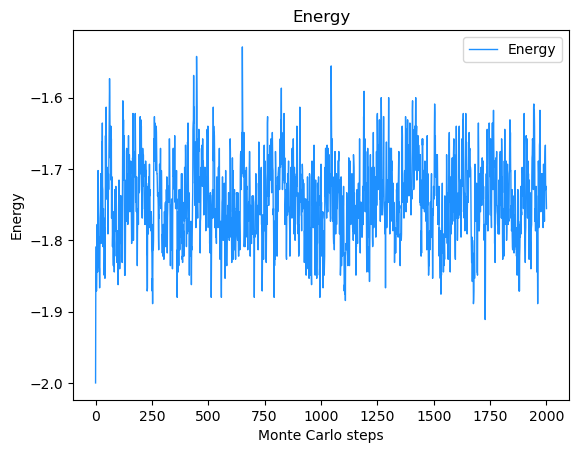

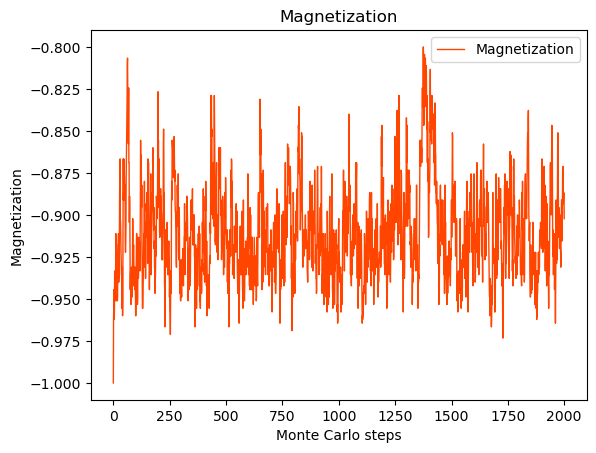

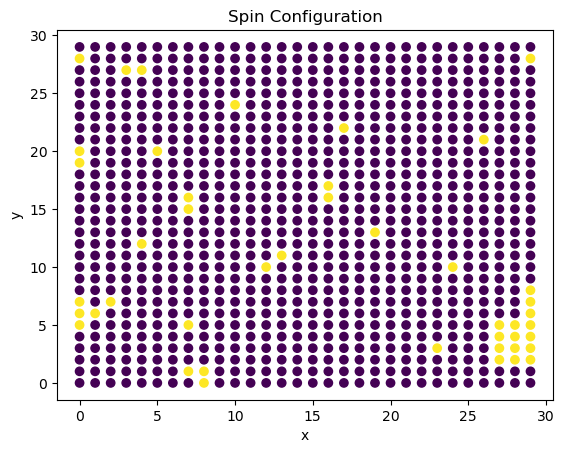

In [17]:
ising = Ising(30,2,J,k_B,'PBC',1000,1000,spin_i='minus_one')
ising.ising_driver()
ising.get_stats()

plt.title('Energy')
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

Spin initialization: half
Total number of steps run = 2000.0
Acceptance ratio = 0.08935222222222222
Temperature = 2
<E/N> = -1.7143339441390415
<M/N> = -0.8171103337220279
Specific Heat = 2.0408569617129655
Magnetic Susceptibility = 14.308934693628236


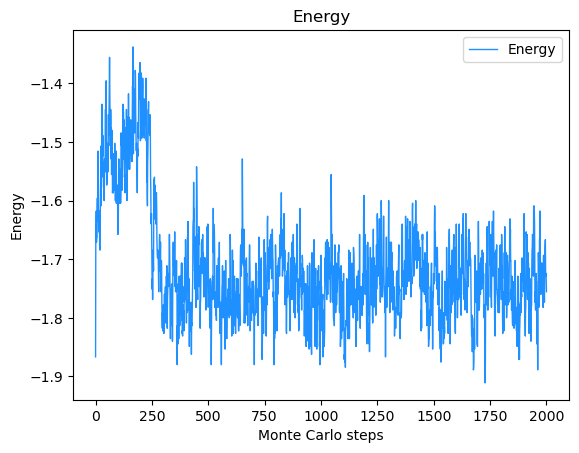

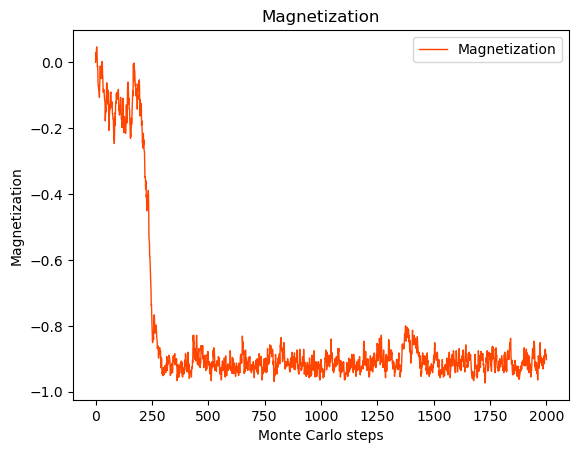

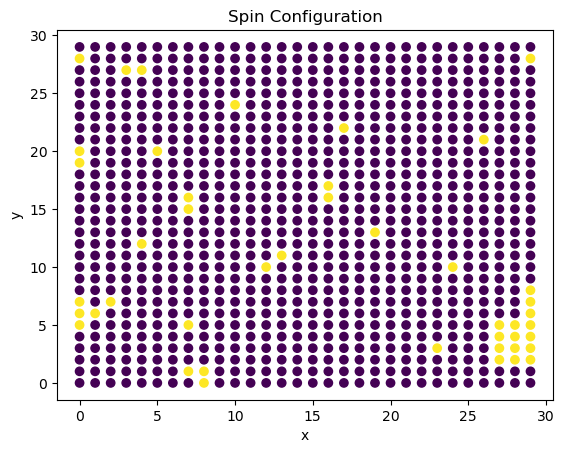

In [18]:
ising = Ising(30,2,J,k_B,'PBC',1000,1000,spin_i='half')
ising.ising_driver()
ising.get_stats()

plt.title('Energy')    
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

(d) Change the temperature T by varying it from 1 to 4 with steps of $\Delta T = 0.5$. Consider runs long enough, so that the equilibrium has been reached and enough statistical data are collected. Calculate ⟨E⟩/N, ⟨M⟩/N, $C$ and $\chi$; plot these quantities as functions of T.  Can you estimate from the plots the critical temperature (whose value $T_c = 2.269 J/k_B$ for 2D is known in case)? Calculate numerically $C$ both in terms of energy fluctuations and doing the numerical derivative with respect to the temperature. Compare the results.

We expect a divergence for specific heat and magnetic sucseptibility at T=2.269, in this case the divergence is not clear.

In [19]:
res=[]
der=np.zeros((2,7))
T_list = [1.0,1.5,2.0,2.5,3.0,3.5,4.0]
T_list=np.array(T_list)
for T in T_list:
    ising = Ising(30,T,J,k_B,'PBC',1000,1000)
    ising.ising_driver()
    ising.get_stats(display=False)
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)

for j in range(6):
    for i in [0,1]:
        der[i,j]=(res[j+1,i]-res[j,i])/0.5

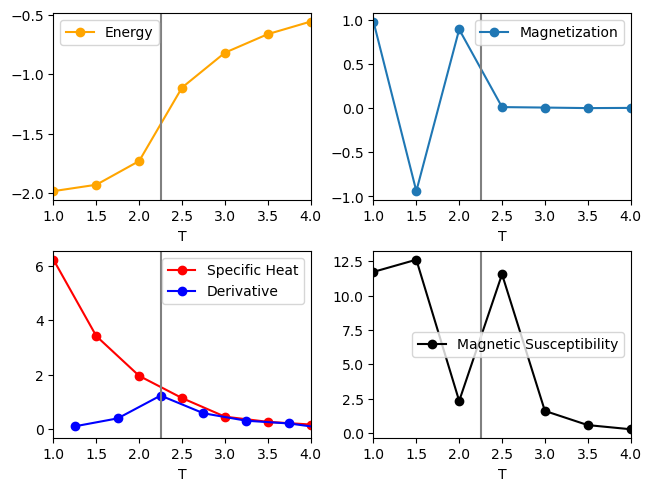

In [20]:
#plotting as a function of temperature
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2,layout="constrained")
    axs[0,0].plot(T_list,res[:,0],'o-',c='orange',label='Energy')
    axs[0,1].plot(T_list,res[:,1],'o-',label='Magnetization')
    axs[1,0].plot(T_list,res[:,2],'o-',c='red',label='Specific Heat')
    axs[1,0].plot(T_list+0.25,der[0,:],'o-',c='blue',label='Derivative')
    axs[1,1].plot(T_list,res[:,3],'o-',c='k',label='Magnetic Susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.set_xlim([1,4])
            ax.axvline(x=2.26,c='grey')
plot_res(T_list,res)

(e) Repeat now (d) with L=4. Comment the results.

At this temperature the divergence is clearer, although it is difficult to say the correct temperature.

In [21]:
res=[]
for T in T_list:
    ising = Ising(4,T,J,k_B,'PBC',1000,1000)
    ising.ising_driver()
    ising.get_stats(display=False)
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)

for j in range(6):
    for i in [0,1]:
        der[i,j]=(res[j+1,i]-res[j,i])/0.5

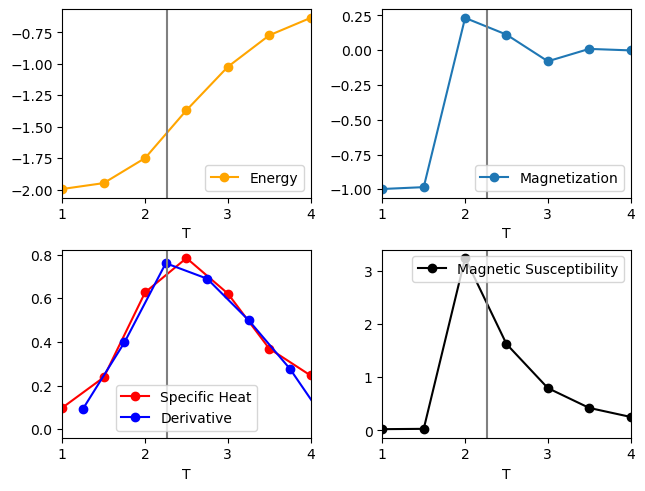

In [22]:
#plotting as a function of temperature
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2,layout="constrained")
    axs[0,0].plot(T_list,res[:,0],'o-',c='orange',label='Energy')
    axs[0,1].plot(T_list,res[:,1],'o-',label='Magnetization')
    axs[1,0].plot(T_list,res[:,2],'o-',c='red',label='Specific Heat')
    axs[1,0].plot(T_list+0.25,der[0,:],'o-',c='blue',label='Derivative')
    axs[1,1].plot(T_list,res[:,3],'o-',c='k',label='Magnetic Susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.set_xlim([1,4])
            ax.axvline(x=2.26,c='grey')
plot_res(T_list,res)

(f) Consider the case with open boundary conditions. (Modify the relevant parts of the code concerning the calculation of the energy.) Repeat some runs with L=30 and L=4. Comment the results.

We see that the convergence is slower, there are fewer interactions.
The magnetization and energy are smaller.
It seems like the phase transitions are for smaller temperatures.

Spin initialization: random
Total number of steps run = 2000.0
Acceptance ratio = 0.12357833333333333
Temperature = 2
<E/N> = -1.5751446498972737
<M/N> = 0.7671319895607751
Specific Heat = 1.7977075818801274
Magnetic Susceptibility = 3.751543818850769


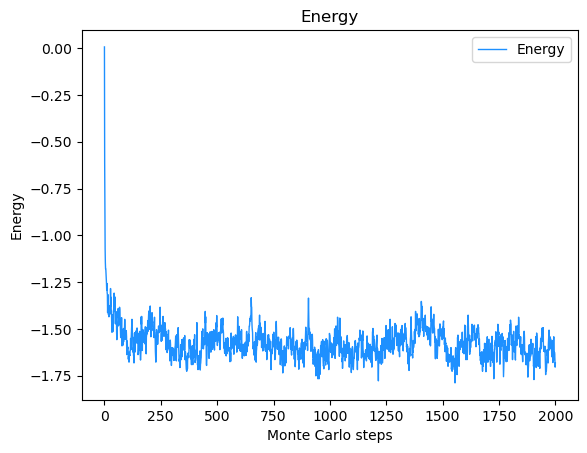

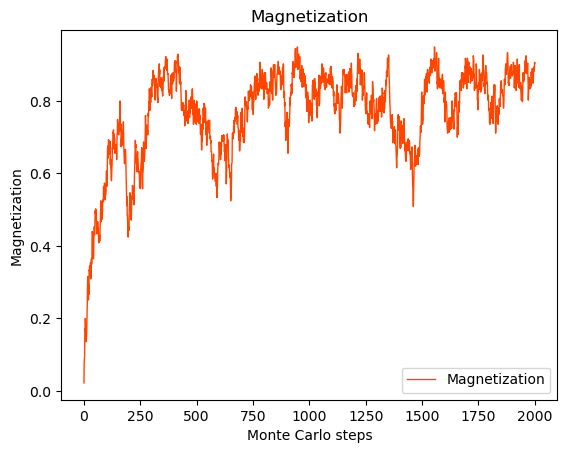

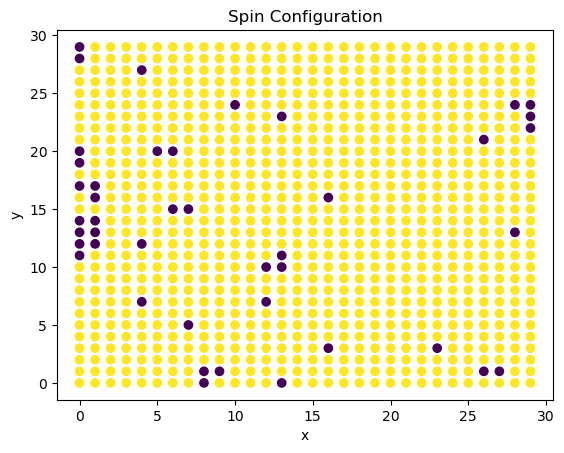

In [23]:
ising = Ising(30,2,J,k_B,'OBC',1000,1000)
ising.ising_driver()
ising.get_stats()

plt.title('Energy')    
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

Spin initialization: random
Total number of steps run = 2000.0
Acceptance ratio = 0.6119088888888888
Temperature = 4
<E/N> = -0.5369104336720529
<M/N> = 0.00026098062080071076
Specific Heat = 0.17054308566744616
Magnetic Susceptibility = 0.26900013899985425


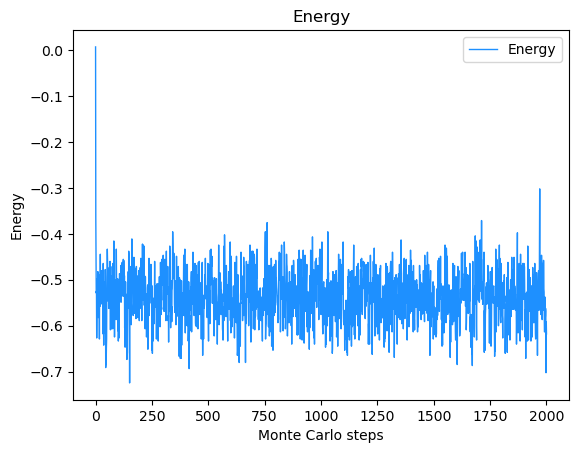

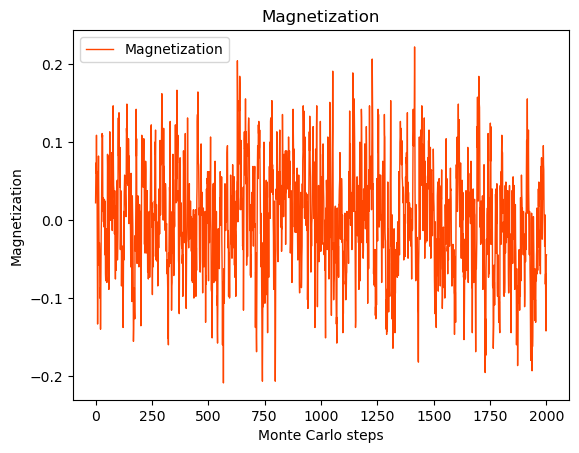

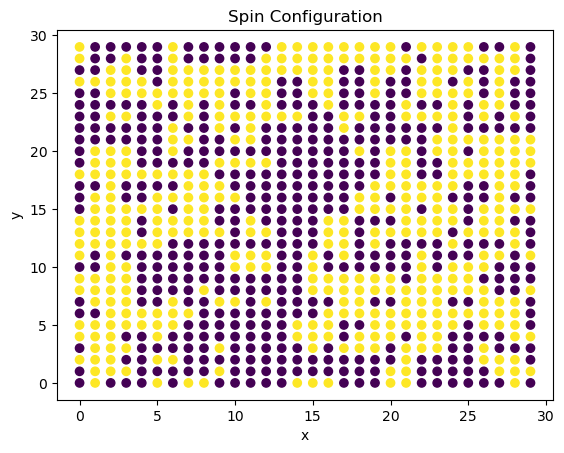

In [25]:
ising = Ising(30,4,J,k_B,'OBC',1000,1000)
ising.ising_driver()
ising.get_stats()


plt.title('Energy')    
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

In [26]:
res=[]
for T in T_list:
    ising = Ising(30,T,J,k_B,'OBC',1000,1000)
    ising.ising_driver()
    ising.get_stats(display=False)
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)

for j in range(6):
    for i in [0,1]:
        der[i,j]=(res[j+1,i]-res[j,i])/0.5

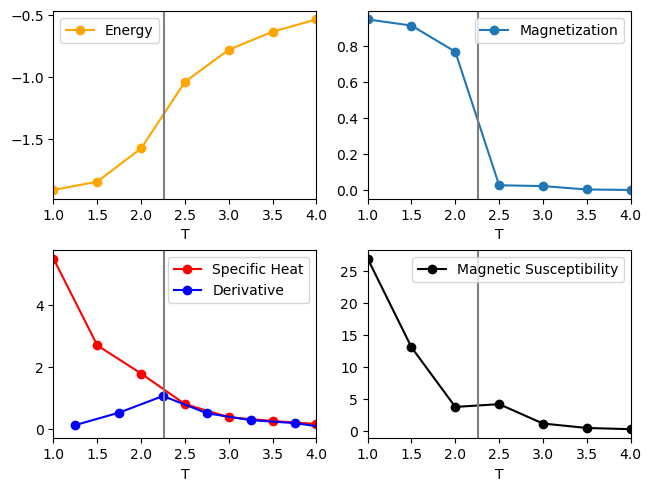

In [27]:
#plotting as a function of temperature
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2,layout="constrained")
    axs[0,0].plot(T_list,res[:,0],'o-',c='orange',label='Energy')
    axs[0,1].plot(T_list,np.abs(res[:,1]),'o-',label='Magnetization')
    axs[1,0].plot(T_list,res[:,2],'o-',c='red',label='Specific Heat')
    axs[1,0].plot(T_list+0.25,der[0,:],'o-',c='blue',label='Derivative')
    axs[1,1].plot(T_list,res[:,3],'o-',c='k',label='Magnetic Susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.set_xlim([1,4])
            ax.axvline(x=2.26,c='grey')
plot_res(T_list,res)

In [28]:
res=[]

for T in T_list:
    ising = Ising(4,T,J,k_B,'OBC',1000,1000)
    ising.ising_driver()
    ising.get_stats(display=False)
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)

for j in range(6):
    for i in [0,1]:
        der[i,j]=(res[j+1,i]-res[j,i])/0.5

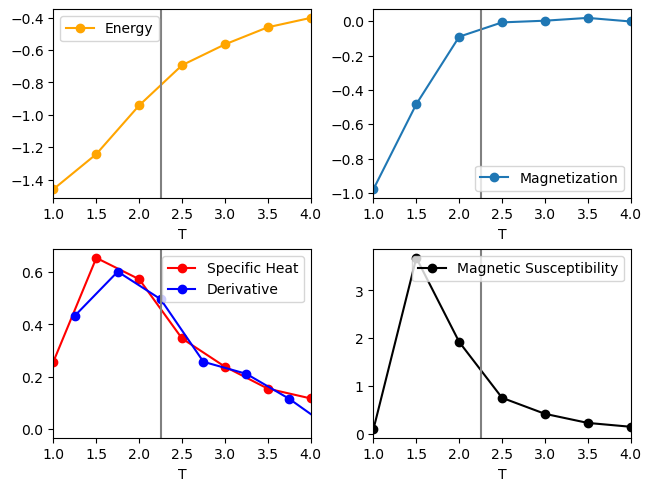

In [29]:
#plotting as a function of temperature
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2,layout="constrained")
    axs[0,0].plot(T_list,res[:,0],'o-',c='orange',label='Energy')
    axs[0,1].plot(T_list,res[:,1],'o-',label='Magnetization')
    axs[1,0].plot(T_list,res[:,2],'o-',c='red',label='Specific Heat')
    axs[1,0].plot(T_list+0.25,der[0,:],'o-',c='blue',label='Derivative')
    axs[1,1].plot(T_list,res[:,3],'o-',c='k',label='Magnetic Susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.set_xlim([1,4])
            ax.axvline(x=2.26,c='grey')
plot_res(T_list,res)

(g) In ising.f90 the numerical estimate of E and M is implemented by updating E at each MC step over the whole lattice, i.e. after one (on average) trial move for all the spins, chosen randomly one at a time. Choose for instance L=30 and a certain value of T. Can you see any difference if you choose the spins to flip in an ordered sequence?

We see no particular difference between the two plots, the number of equilibration steps is smaller.
Variance

Spin initialization: random
Total number of steps run = 2000.0
Acceptance ratio = 0.08004444444444445
Temperature = 2
<E/N> = -1.7428463546004775
<M/N> = 0.9085701593647622
Specific Heat = 1.3560009755795666
Magnetic Susceptibility = 0.47350537846738006


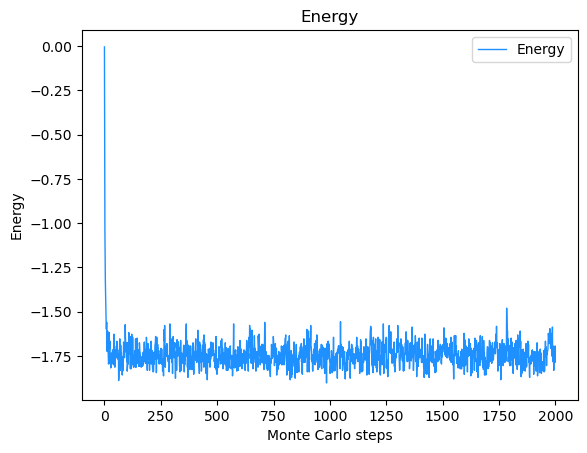

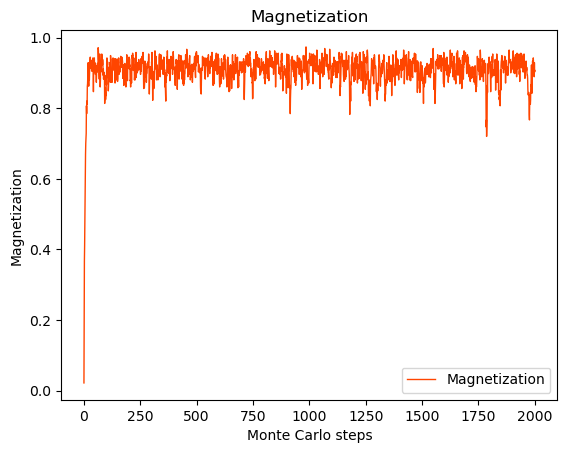

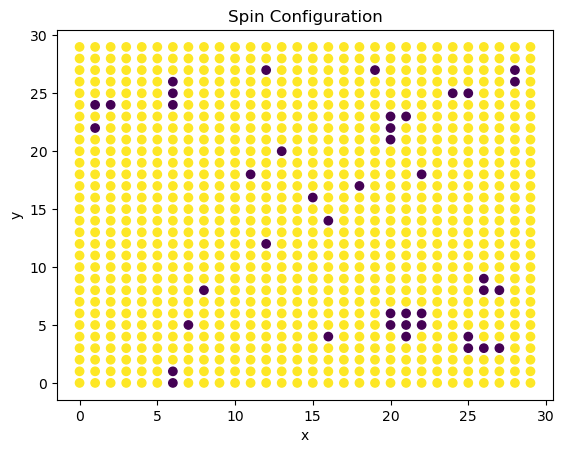

In [31]:
ising = Ising(30,2,J,k_B,'PBC',1000,1000,mc_step_selection='ordered')
ising.ising_driver()
ising.get_stats()

plt.title('Energy')    
plt.plot(ising.data[:,0]/ising.N,'-',lw=1,label=r'Energy',color="#1E90FF")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data[:,1]/ising.N,'-',lw=1,label=r'Magnetization',color="#FF4500")
plt.xlabel('Monte Carlo steps')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

ising.plot_spin(ising.spin)

(h) Instead of updating E after each MC step over all the spins, do it for each configuration, i.e. after each single MC step per spin. Compare some results obtained with the two methods, and discuss whether the two methods are equivalent or not.

In this perspective we see that the two approches are not equivalent.

Spin initialization: random
Total number of steps run = 2000.0
Acceptance ratio = 0.08403222222222222
Temperature = 2
<E/N> = -1.7302615358987172
<M/N> = 0.8896873785329558
Specific Heat = 1.9585077093303618
Magnetic Susceptibility = 2.3228400514607266
Spin initialization: random
Total number of steps run = 2000.0
Acceptance ratio = 0.08004444444444445
Temperature = 2
<E/N> = -1.7428463546004775
<M/N> = 0.9085701593647622
Specific Heat = 1.3560009755795666
Magnetic Susceptibility = 0.47350537846738006


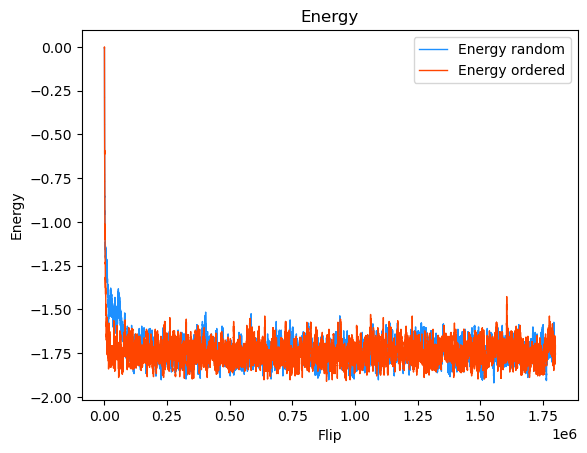

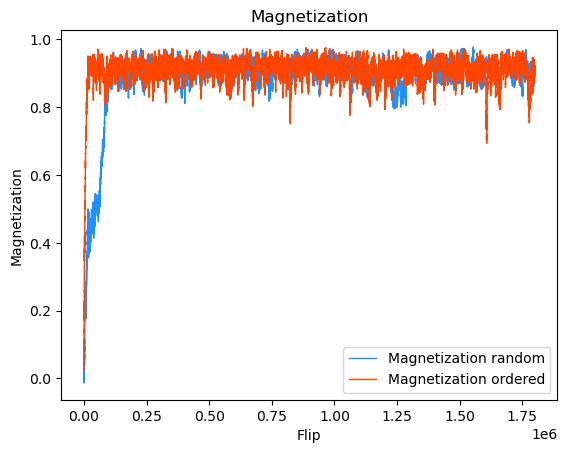

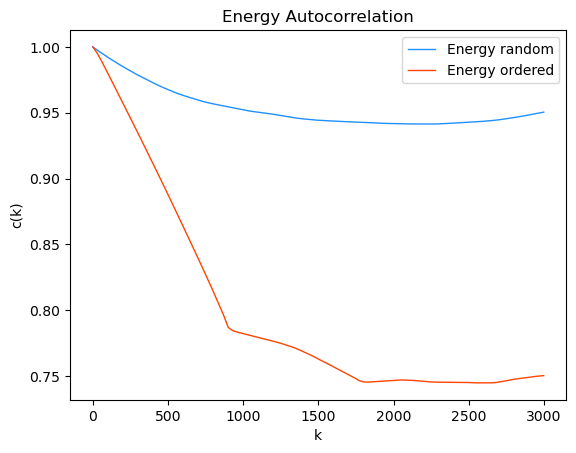

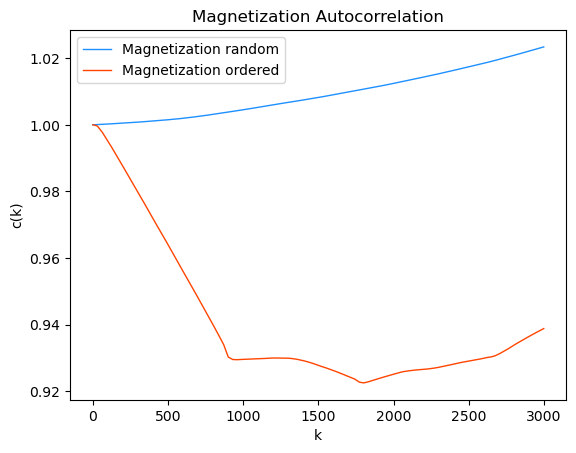

In [57]:
ising = Ising(30,2,J,k_B,'PBC',1000,1000)
ising.ising_driver()
ising.get_stats()
isin = Ising(30,2,J,k_B,'PBC',1000,1000,mc_step_selection='ordered')
isin.ising_driver()
isin.get_stats()

plt.title('Energy')
plt.plot(ising.data_[:,0]/ising.N,'-',lw=1,label=r'Energy random',color="#1E90FF")
plt.plot(isin.data_[:,0]/ising.N,'-',lw=1,label=r'Energy ordered',color="#FF4500")
plt.xlabel('Flip')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.title('Magnetization')    
plt.plot(ising.data_[:,1]/ising.N,'-',lw=1,label=r'Magnetization random',color="#1E90FF")
plt.plot(isin.data_[:,1]/ising.N,'-',lw=1,label=r'Magnetization ordered',color="#FF4500")
plt.xlabel('Flip')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

plt.title('Energy Autocorrelation')    
plt.plot(ising.calc_autocorr(ising.data_[:,0],3000),'-',lw=1,label=r'Energy random',color="#1E90FF")
plt.plot(ising.calc_autocorr(isin.data_[:,0],3000),'-',lw=1,label=r'Energy ordered',color="#FF4500")
plt.xlabel('k')
plt.ylabel('c(k)')
plt.legend()
plt.show()

plt.title('Magnetization Autocorrelation')    
plt.plot(ising.calc_autocorr(ising.data_[:,1],3000),'-',lw=1,label=r'Magnetization random',color="#1E90FF")
plt.plot(ising.calc_autocorr(isin.data_[:,1],3000),'-',lw=1,label=r'Magnetization ordered',color="#FF4500")
plt.xlabel('k')
plt.ylabel('c(k)')
plt.legend()
plt.show()

#Autocorrelazione all'equilibrio, perché la fase transiente non è statisticamente significativa, vi sono altri effetti in gioco
#Mi spiego l'autocorrelazione della magnetizzazione perché in un ciclo riesco a flippare tutti gli spin
#L'energia dipende dal passo precedente
#L'autocorrelazione ci dice la grandezza dei blocchi per la quale non serve considerare la correlazione

In [58]:
print("Energy Variance random",np.std(ising.data[:,0]/900))
print("Energy Variance order",np.std(isin.data[:,0]/900))

print("Magnetization Variance random",np.std(ising.data[:,1]/900))
print("Magnetization Variance order",np.std(isin.data[:,1]/900))


Energy Variance random 0.09329779583749635
Energy Variance order 0.07763163660890182
Magnetization Variance random 0.1016057752396377
Magnetization Variance order 0.04587448472456171


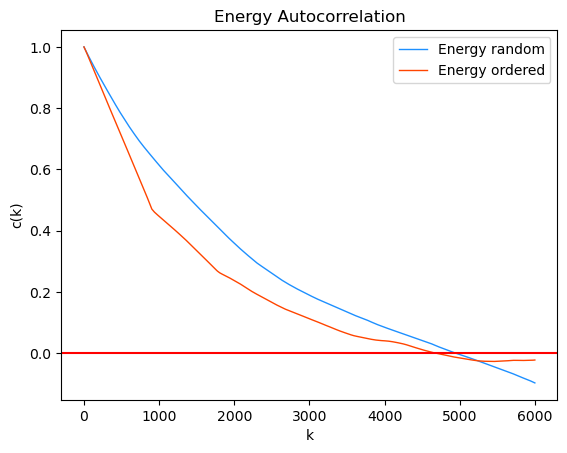

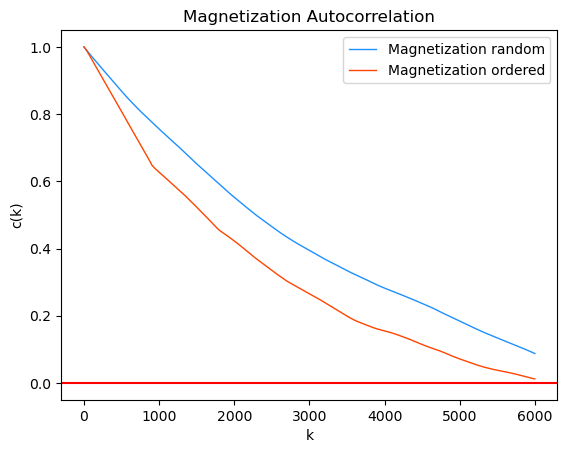

In [61]:
plt.title('Energy Autocorrelation')    
plt.plot(ising.calc_autocorr(ising.data_[250*900:,0],6000),'-',lw=1,label=r'Energy random',color="#1E90FF")
plt.plot(ising.calc_autocorr(isin.data_[250*900:,0],6000),'-',lw=1,label=r'Energy ordered',color="#FF4500")
plt.axline((0,0), (1,0), color="red")
plt.xlabel('k')
plt.ylabel('c(k)')
plt.legend()
plt.show()

plt.title('Magnetization Autocorrelation')    
plt.plot(ising.calc_autocorr(ising.data_[250*900:,1],6000),'-',lw=1,label=r'Magnetization random',color="#1E90FF")
plt.plot(ising.calc_autocorr(isin.data_[250*900:,1],6000),'-',lw=1,label=r'Magnetization ordered',color="#FF4500")
plt.axline((0,0), (1,0), color="red")
plt.xlabel('k')
plt.ylabel('c(k)')
plt.legend()
plt.show()

In [80]:
b_e_ = np.split(isin.data_[1:,0]/900,300)
b_m_ = np.split(isin.data_[1:,1]/900,300)

res_e=np.zeros(300)
res=np.zeros(300)

for i in range(300):
    res_e[i]=np.mean(b_e_[i])
    res[i]=np.mean(b_m_[i])
    
energy=np.mean(res_e)
std_e=np.std(res_e)
magnetization=np.mean(res)
std=np.std(res)

display(Math(r'\text{{Energy}}= {} \pm {}'.format(energy, std_e)))
display(Math(r'\text{{Magnetization}}= {} \pm {}'.format(magnetization, std)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [79]:
b_e_ = np.split(ising.data_[1:,0]/900,300)
b_m_ = np.split(ising.data_[1:,1]/900,300)

res_e=np.zeros(300)
res=np.zeros(300)

for i in range(300):
    res_e[i]=np.mean(b_e_[i])
    res[i]=np.mean(b_m_[i])
    
energy=np.mean(res_e)
std_e=np.std(res_e)
magnetization=np.mean(res)
std=np.std(res)

display(Math(r'\text{{Energy}}= {} \pm {}'.format(energy, std_e)))
display(Math(r'\text{{Magnetization}}= {} \pm {}'.format(magnetization, std)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(i) (optional) It is interesting also to visualise the variation of the spin pattern during the evolution. It can be done using gnuplot. (Example available on moodle)

In [6]:
ising = Ising(30,2,J,k_B,"PBC",1000,1000,fortran=True,gif_spin=True)
ising.ising_driver()

In [5]:
%load_ext line_profiler

In [6]:
ising = Ising(30,2,J,k_B,"PBC",1000,1000, fortran=True)
%lprun -f ising.metro_step ising.ising_driver()

Timer unit: 1e-09 s

Total time: 0.117376 s
File: /tmp/ipykernel_356/3260869891.py
Function: metro_step at line 263

Line #      Hits         Time  Per Hit   % Time  Line Contents
   263                                               def metro_step(self):
   264                                                   'One step of Metropolis spin flip dynamics'
   265      2000     468143.0    234.1      0.4          if self.fortran:
   266      2000  107136980.0  53568.5     91.3              isingf.metropolis()
   267      2000     744810.0    372.4      0.6              self.M = isingf.m
   268      2000    4394385.0   2197.2      3.7              self.M_N = self.M/float(self.N)
   269      2000     642269.0    321.1      0.5              self.E = isingf.e
   270      2000    2983950.0   1492.0      2.5              self.E_N = self.E/float(self.N)
   271      2000    1005328.0    502.7      0.9              self.acc=isingf.accept
   272                                                   else

In [7]:
ising = Ising(30,2,J,k_B,"PBC",1000,1000)
%lprun -f ising.metro_step ising.ising_driver()

Timer unit: 1e-09 s

Total time: 42.9035 s
File: /tmp/ipykernel_356/3260869891.py
Function: metro_step at line 263

Line #      Hits         Time  Per Hit   % Time  Line Contents
   263                                               def metro_step(self):
   264                                                   'One step of Metropolis spin flip dynamics'
   265      2000    1796245.0    898.1      0.0          if self.fortran:
   266                                                       isingf.metropolis()
   267                                                       self.M = isingf.m
   268                                                       self.M_N = self.M/float(self.N)
   269                                                       self.E = isingf.e
   270                                                       self.E_N = self.E/float(self.N)
   271                                                       self.acc=isingf.accept
   272                                                   else: